In [1]:
# Importação e configuração das bibliotecas necessárias para este projeto

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
# Carregamento e preparação

def load_data(path):
    df = pd.read_csv(path, sep=';')
    cicles = sorted(df['COD_CICLO'].unique())
    cicles_to_date = {c: pd.to_datetime("2018-01-01") + pd.DateOffset(months=i) for i, c in enumerate(cicles)}
    df['DATA'] = df['COD_CICLO'].map(cicles_to_date)
    df = df.sort_values('DATA')
    return df

In [3]:
# Funções de análise básica

def validate_data(df):
    print("\n--- Informações do Dataset ---")
    print(df.info())
    print("\n--- Valores Ausentes ---")
    print(df.isnull().sum())
    print("\n--- Duplicatas ---")
    print(df.duplicated().sum())
    print("\n--- Estatísticas Descritivas ---")
    print(df.describe())

def convert(df):
    df['QT_VENDA_BRUTO'] = (
        df['QT_VENDA_BRUTO']
        # Garante que seja string
        .astype(str)  
        # Remove tudo que não é dígito, ponto, vírgula ou hífen
        .str.replace(r'[^\d,.-]', '', regex=True)  
        # Troca vírgula por ponto
        .str.replace(',', '.', regex=False) 
        .str.strip()
    )
    df['QT_VENDA_BRUTO'] = pd.to_numeric(df['QT_VENDA_BRUTO'], errors='coerce')
    
    df['QT_DEVOLUCAO'] = df['QT_DEVOLUCAO'].fillna(0)

    return df

def aggregate_monthly_sales(df):
    monthly_df = df.groupby('DATA').agg({'QT_VENDA_BRUTO': 'sum'}).reset_index()
    monthly_df.set_index('DATA', inplace=True)
    return monthly_df

In [4]:
# Funções de análise temporal global

def analyze_time_series(df):
    df_monthly = df.groupby('DATA').agg(sales=('QT_VENDA_BRUTO', 'sum')).reset_index()
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df_monthly, x='DATA', y='sales', marker='o')
    plt.title('Tendência de vendas ao longo do tempo')
    plt.xlabel('Data')
    plt.ylabel('Vendas brutas')
    plt.tight_layout()
    plt.show()
    return df_monthly

In [5]:
# Funções de análise por grupo

def plot_sales_by_group(df, column, title):
    df_agg = df.groupby(column).agg(sales=('QT_VENDA_BRUTO', 'sum')).reset_index().sort_values('sales', ascending=False)
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_agg, x=column, y='sales')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def analyze_temporal_sales_by_group(df, group):
    df_agg = df.groupby(['DATA', group]).agg(sales=('QT_VENDA_BRUTO', 'sum')).reset_index()
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=df_agg, x='DATA', y='sales', hue=group, marker='o')
    plt.title(f'Evolução de vendas por {group}')
    plt.ylabel('Vendas brutas')
    plt.tight_layout()
    plt.show()

In [6]:
# Distribuição de cauda longa e ajuste de Pareto

def check_heavy_tail(df):
    
    sales_by_brand = df.groupby('DES_MARCA_MATERIAL')['QT_VENDA_BRUTO'].sum()
    sales_by_brand = sales_by_brand.sort_values(ascending=False)

    tail = sales_by_brand[sales_by_brand > sales_by_brand.median()]

    pareto_params = stats.pareto.fit(tail)
    lognorm_params = stats.lognorm.fit(tail)
    cauchy_params = stats.cauchy.fit(tail)

    # Teste KS (Kolmogorov-Smirnov)
    
    ks_pareto = stats.kstest(tail, 'pareto', args=pareto_params)
    ks_lognorm = stats.kstest(tail, 'lognorm', args=lognorm_params)
    ks_cauchy = stats.kstest(tail, 'cauchy', args=cauchy_params)

    print(f"KS Pareto: {ks_pareto.statistic:.4f} | p-value: {ks_pareto.pvalue:.4f}")
    print(f"KS Log-normal: {ks_lognorm.statistic:.4f} | p-value: {ks_lognorm.pvalue:.4f}")
    print(f"KS Cauchy: {ks_cauchy.statistic:.4f} | p-value: {ks_cauchy.pvalue:.4f}")

    # Estimar índice de Hill

    log_x = np.log(tail.values)
    log_x_sorted = np.sort(log_x)[::-1]
    k = int(len(log_x_sorted) * 0.2)  # usar 20% maiores
    hill_index = (1 / k) * np.sum(log_x_sorted[:k] - log_x_sorted[k])
    print(f"Índice de Hill (estimado): {hill_index:.4f}")

    # Interpretação

    if hill_index > 1:
        print("➡️ Indica cauda pesada (decai lentamente, variância finita).")
    elif 0 < hill_index <= 1:
        print("Cauda extremamente pesada (variância infinita).")
    else:
        print(" Não é uma distribuição de cauda pesada.")   

In [7]:
# Visualizações

def calculate_sales_by_brand(df):
    return df.groupby('DES_MARCA_MATERIAL')['QT_VENDA_BRUTO'].sum().sort_values(ascending=False)


def split_top_tail(serie, quantil=0.90):
    limit = serie.quantile(quantil)
    top = serie[serie >= limit]
    tail = serie[serie < limit]
    return top, tail, limit

def plot_distribution(transformed):
    plt.figure(figsize=(7, 5))
    sns.histplot(transformed, bins=30, color='orange', kde=True)
    plt.title("Distribuição log1p das vendas por marca")
    plt.xlabel("log1p(Vendas)")
    plt.tight_layout()
    plt.show()

def plot_top_vs_tail(top, tail):
    plt.figure(figsize=(12, 5))
    plt.bar(top.index, top.values, label='Top 10% marcas', color='darkblue')
    plt.bar(tail.index, tail.values, label='Cauda longa (90%)', color='gray')
    plt.xticks(rotation=90)
    plt.title("Vendas por marca: top vs cauda longa")
    plt.ylabel("Vendas totais")
    plt.legend()
    plt.tight_layout()
    plt.show()

def impact_events(df):
    events = df.groupby(['DATA', 'FLG_DATA']).agg(sales=('QT_VENDA_BRUTO', 'sum')).reset_index()
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=events, x='DATA', y='sales', hue='FLG_DATA', marker='o')
    plt.title('Impacto de datas comemorativas nas vendas')
    plt.ylabel('Vendas brutas')
    plt.tight_layout()
    plt.show()


--- Informações do Dataset ---
<class 'pandas.core.frame.DataFrame'>
Index: 173923 entries, 68524 to 118582
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   COD_CICLO               173923 non-null  int64         
 1   FLG_DATA                173923 non-null  int64         
 2   COD_MATERIAL            173923 non-null  int64         
 3   COD_CANAL               173923 non-null  object        
 4   DES_CATEGORIA_MATERIAL  173923 non-null  object        
 5   DES_MARCA_MATERIAL      173923 non-null  object        
 6   COD_REGIAO              173923 non-null  object        
 7   QT_VENDA_BRUTO          173923 non-null  object        
 8   QT_DEVOLUCAO            87164 non-null   float64       
 9   VL_RECEITA_BRUTA        173923 non-null  object        
 10  VL_RECEITA_LIQUIDA      173923 non-null  object        
 11  FLG_CAMPANHA_MKT_A      173923 non-null  int64         
 12 

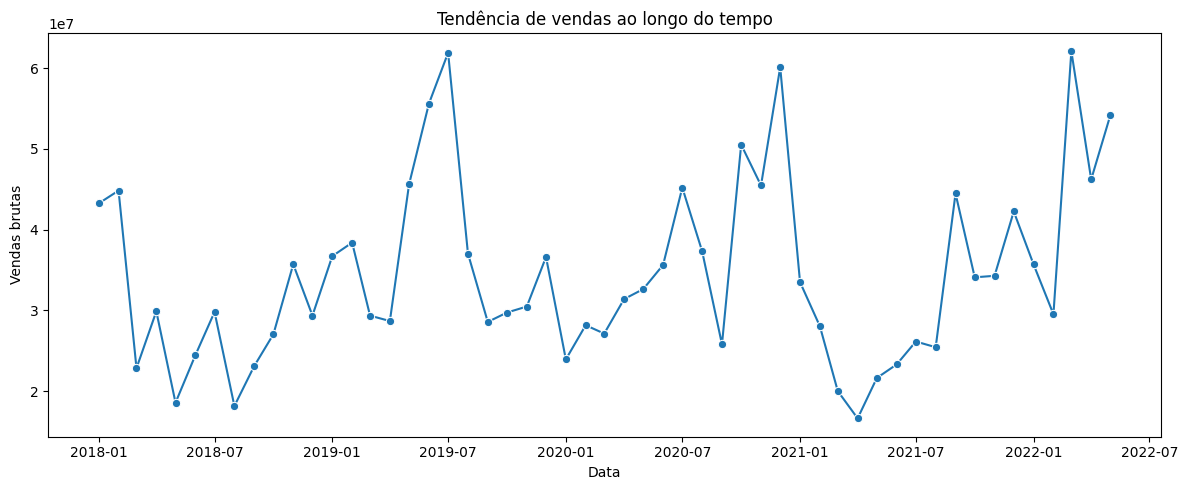

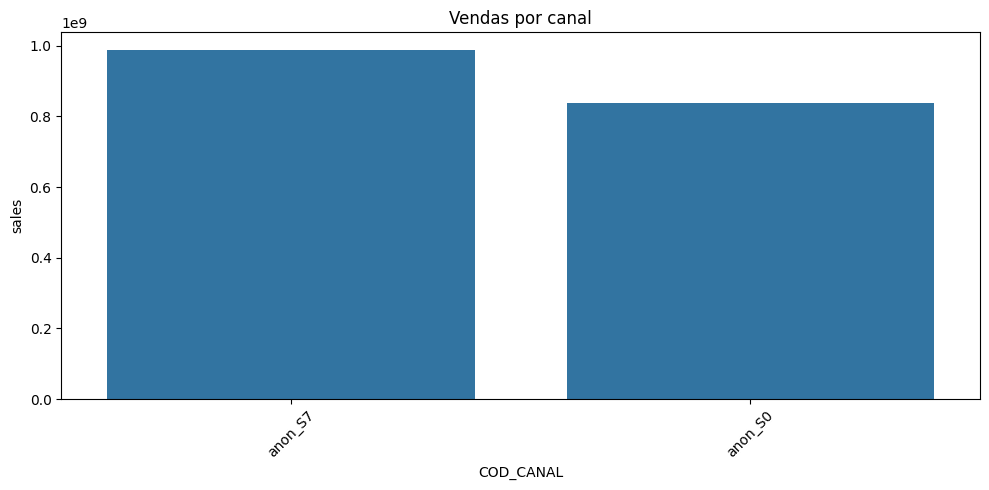

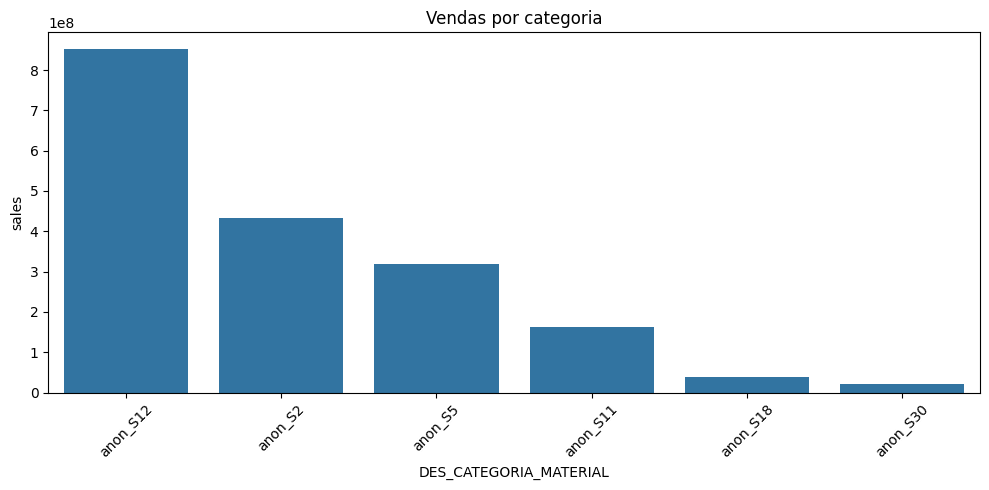

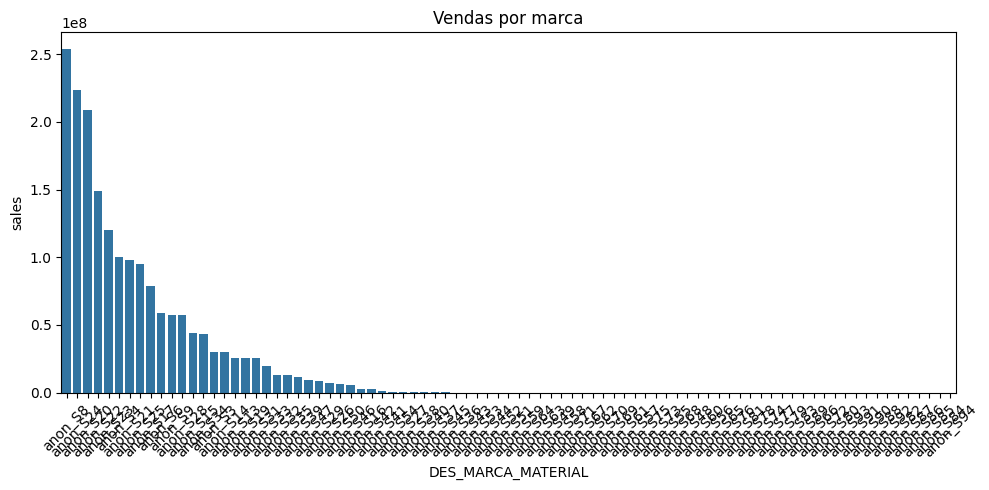

KS Pareto: 0.1692 | p-value: 0.1608
KS Log-normal: 0.1563 | p-value: 0.2312
KS Cauchy: 0.3273 | p-value: 0.0002
Índice de Hill (estimado): 0.6109
Cauda extremamente pesada (variância infinita).


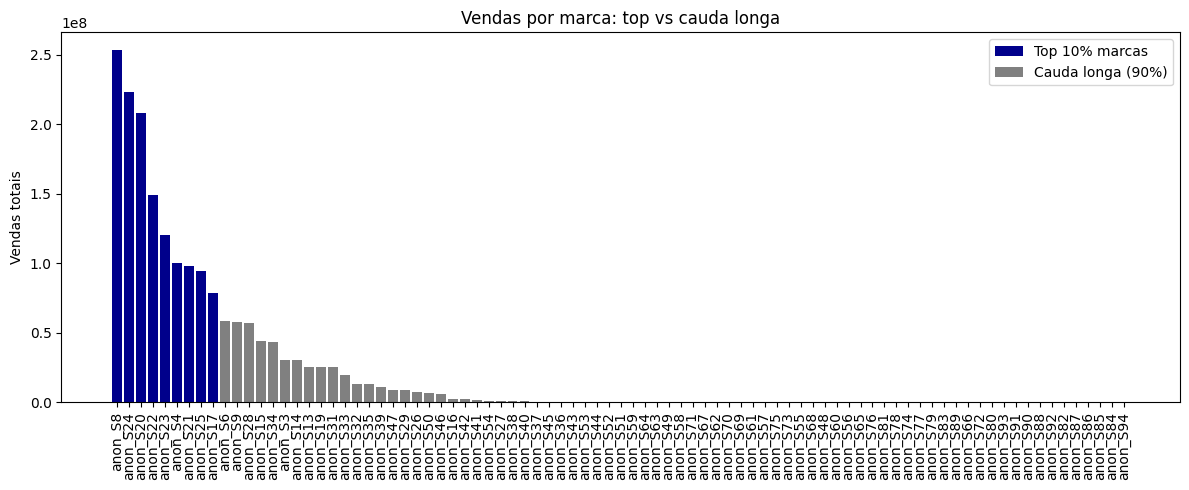

Top marcas: 9
Cauda longa: 76
Limite top 10%: 70,694,452.89


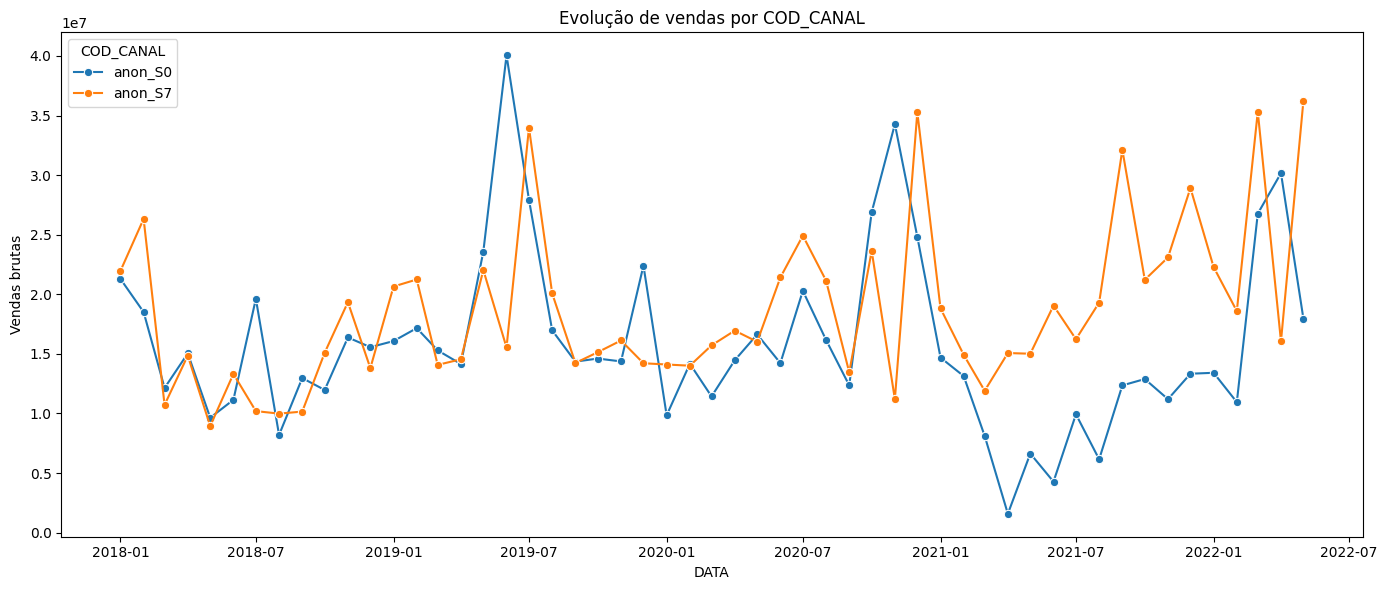

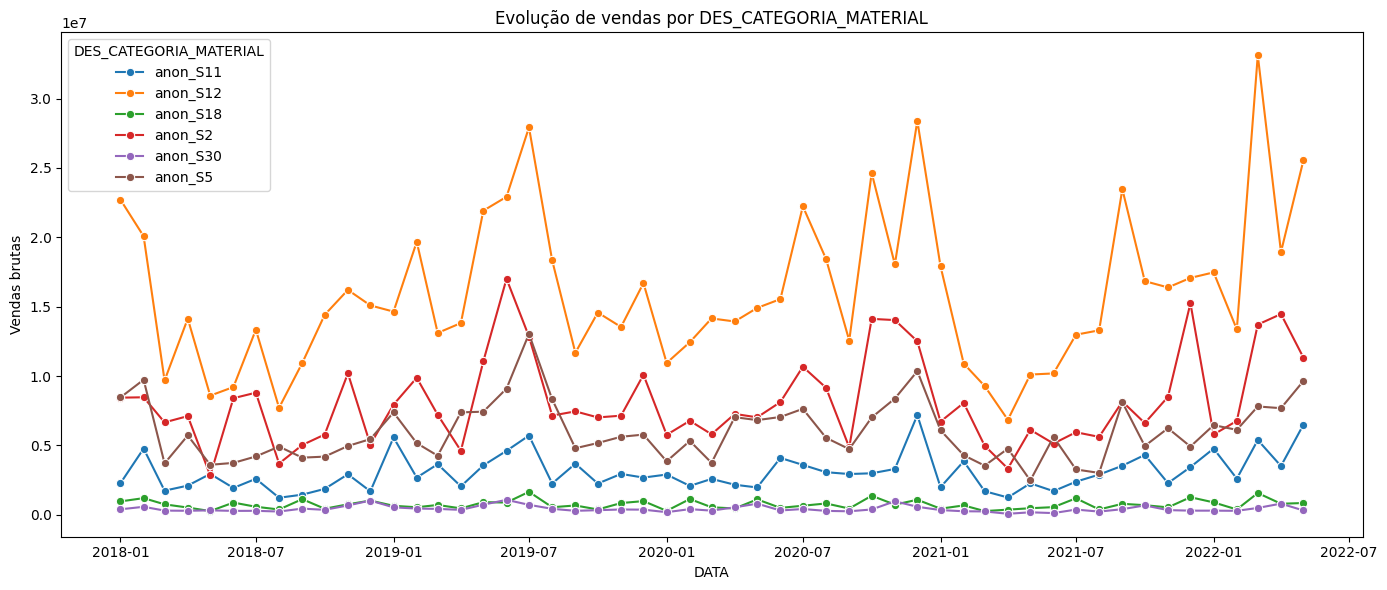

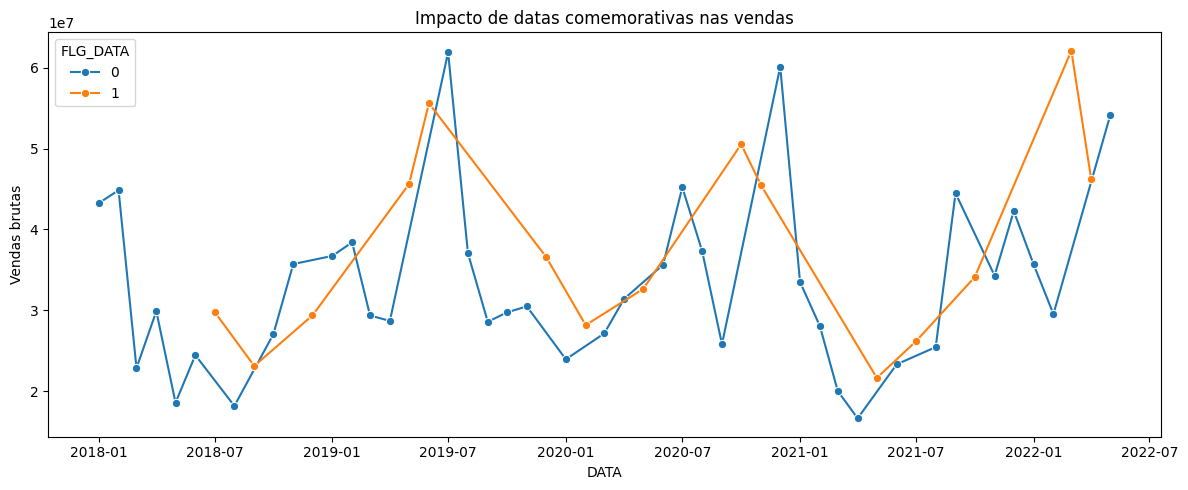

In [8]:
# Pipeline de Execução

ROOT_DIR = Path.cwd().parent
data_path = ROOT_DIR /"data"/"dataset.csv"

df = load_data(data_path)
validate_data(df)
convert(df)

aggregate_monthly_sales(df)

# Exportar data frame

df_processed = df.copy()  
df_processed.to_csv(ROOT_DIR /"data"/"processed"/"processed_dataset.csv", index=False)

analyze_time_series(df_processed)

plot_sales_by_group(df_processed, 'COD_CANAL', 'Vendas por canal')
plot_sales_by_group(df_processed, 'DES_CATEGORIA_MATERIAL', 'Vendas por categoria')
plot_sales_by_group(df_processed, 'DES_MARCA_MATERIAL', 'Vendas por marca')

check_heavy_tail(df_processed)

sales = calculate_sales_by_brand(df_processed)
top, tail, limit = split_top_tail(sales, quantil=0.90)

plot_top_vs_tail(top, tail)

print(f"Top marcas: {top.shape[0]}\nCauda longa: {tail.shape[0]}\nLimite top 10%: {limit:,.2f}")

analyze_temporal_sales_by_group(df_processed, 'COD_CANAL')
analyze_temporal_sales_by_group(df_processed, 'DES_CATEGORIA_MATERIAL')

impact_events(df_processed)  